## Decision Tree Classifier for Customer Churn Prediction

This notebook implements a Decision Tree Classifier to predict customer churn.
The goal is to:
- Capture non-linear feature interactions
- Maintain interpretability
- Compare performance with Logistic Regression


In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [2]:
#Load & Schema Fix
df = pd.read_csv("../dataset/telco_train.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   # 🔥 REQUIRED for KNN
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
preprocessor_knn = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [4]:
df.drop("Churn", axis=1)
# Fix TotalCharges issue
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df["TotalCharges"].isnull().sum()

df["TotalCharges"] = df["TotalCharges"].fillna(
    df["TotalCharges"].median()
)


X = df.drop("Churn", axis=1)
y = df["Churn"].map({"Yes": 1, "No": 0})


In [5]:
X = pd.get_dummies(X, drop_first=True)



In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_knn),
    ("model", KNeighborsClassifier(
        n_neighbors=3,
        metric="minkowski",
        weights="distance"
    ))
])

knn.fit(X_train_scaled, y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",3
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'distance'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7453416149068323
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       828
           1       0.52      0.49      0.51       299

    accuracy                           0.75      1127
   macro avg       0.67      0.66      0.67      1127
weighted avg       0.74      0.75      0.74      1127



In [10]:
confusion_matrix(y_test, y_pred)


array([[693, 135],
       [152, 147]])

In [11]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Accuracy : 0.7453416149068323
Precision: 0.5212765957446809
Recall   : 0.4916387959866221
F1 Score : 0.5060240963855421
ROC AUC  : 0.6642976588628762

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       828
           1       0.52      0.49      0.51       299

    accuracy                           0.75      1127
   macro avg       0.67      0.66      0.67      1127
weighted avg       0.74      0.75      0.74      1127



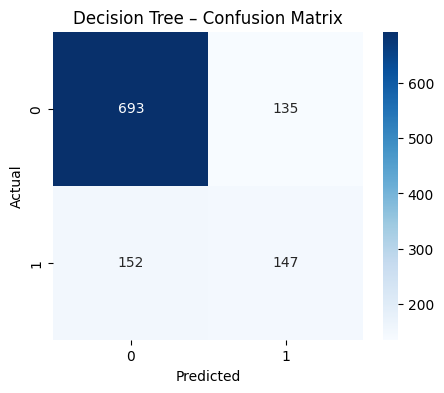

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.show()


In [13]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3,5,7,9,11,15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    scoring='recall',  # or 'f1'
    cv=5
)


grid.fit(X_train_scaled, y_train)

grid.best_params_


{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

In [14]:
best_knn = grid.best_estimator_


In [16]:
y_pred_best = best_knn.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_best >= 0.5).astype(int)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.87      0.85       828
           1       0.60      0.55      0.57       299

    accuracy                           0.78      1127
   macro avg       0.72      0.71      0.71      1127
weighted avg       0.78      0.78      0.78      1127



In [18]:
import pickle

with open("../models/knn.pkl", "wb") as f:
    pickle.dump(best_knn, f)

print("Model saved as knn.pkl")


Model saved as knn.pkl
